Video Game Sales Data Challenge

<u>Goal</u>

You work for a data science consulting company. A major video game production company has retained your firm to conduct market research into the video game industry. They've furnished you with video game sales data for the last thirty years (described below) and, as a first project, would like to know:

1.	What are some major differences between the North American, European, and Japanese video game markets?
2.	What video game genres are trending in each market?
3.	What features about a video game are most indicative of its success?

This dataset contains a list of video games with sales greater than 100,000 copies.
Rank - Ranking of overall sales
Name - The games name
Platform - Platform of the games release (i.e. PC,PS4, etc.)
Year - Year of the game's release
Genre - Genre of the game
Publisher - Publisher of the game
NA_Sales - Sales in North America (in millions)
EU_Sales - Sales in Europe (in millions)
JP_Sales - Sales in Japan (in millions)
Other_Sales - Sales in the rest of the world (in millions)
Global_Sales - Total worldwide sales.

<u>General Approach</u>

Questions 1 and 2 fall under the same category of general data exploration, while question 3 falls under the category of fitting a model to understand which features are most predicative of game success. We will start by performing some general EDA (exploratory data analysis), mainly grouping the data by region and year, genre, or platform to understand  underlying trends. Then we will use linear regression and random forest models to try to understand the best predictors of video game success.

# Import necessary libraries

In [282]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

# Import Data

In [352]:
data = pd.read_csv('vgsales.csv')
data.head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


What is the size of the dataframe?

In [353]:
print('The number of games in the dataset is {}\nThe number of columns is {}'.format(data.shape[0], data.shape[1]))

The number of games in the dataset is 16598
The number of columns is 11


Are there any null values?

In [22]:
if data.isnull().values.any():
    print('There are null values in the dataframe.')

There are null values in the dataframe.


Which columns have null values?

In [25]:
for column in data.columns:
    if data[column].isnull().any():
        print('The column "{}" has null values'.format(column))

The column "Year" has null values
The column "Publisher" has null values


Grab lists of unique values for publishers, genres, and platforms

In [206]:
publishers = data['Publisher'].unique()
genres = data['Genre'].unique()
platforms = data['Platform'].unique()

# Differences between NA, EU, and JP markets

## Size of market over all time

What is the maximum global sales for any video game in the market?

In [207]:
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales']

In [208]:
max_in_markets = []
for region in regions:
    max_in_markets.append(data[region].max())
    
print('The max sales for a single video game in any single market is {}'.format(max(max_in_markets)))

The max sales for a single video game in any single market is 41.49


In each market, let's look at the distribution of the number of games that make at least some amount of money. Generally, what we're doing is creating a dictionary for each market where the key is the market name and the value is a list of the number of games having sales greater than a certain amount.

In [209]:
sales_bins = range(1,42)

sales_data = {}
for region in regions:
    sales_list = []
    for sales_bin in sales_bins:
        sales_list.append(data[data[region] > sales_bin].shape[0])
    sales_data[region] = sales_list

Let's visualize the sales data using bar plots 

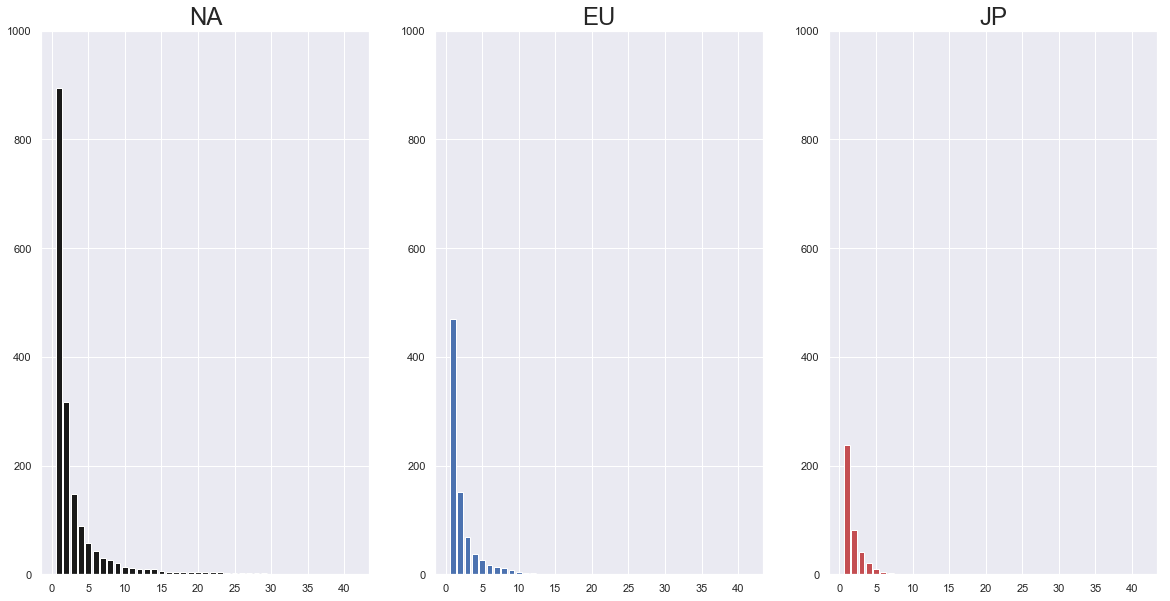

In [211]:
sns.set()
fig, axs = plt.subplots(1, 3, figsize=(20,10))
colors = ['k', 'b', 'r']
titles = ['NA', 'EU', 'JP']

for index in range(3):
    axs[index].bar(sales_bins, sales_data[regions[index]], color=colors[index])
    axs[index].set_ylim(0,1000)
    axs[index].set_title(titles[index], fontsize=24)
fig.savefig('Videogame_sales_across_markets.png', dpi=300, bbox_inches='tight')

Clearly, the NA market is bigger than the EU market, which is bigger than the JP market. Let's find out how big each market is in $

In [72]:
NA_sales = data['NA_Sales'].sum()
EU_sales = data['EU_Sales'].sum()
JP_sales = data['JP_Sales'].sum()
print('NA, EU, and JP sales over all games in the dataset are {:.0f}, {:.0f}, and {:.0f} millions of dollars, respectively.'.format(NA_sales, EU_sales, JP_sales))

NA, EU, and JP sales over all games in the dataset are 4393, 2434, and 1291 millions of dollars, respectively.


## Size of market over time

Here we calculate the size ($) of the NA, EU, and JP markets over time.

In [265]:
data_copy = data.copy()
data_copy.dropna(subset=['Year'], inplace=True)

Calculate the min and max year for the games in the dataset, which we will eventually use to bin the years

In [266]:
data_copy['Year'].max(), data_copy['Year'].min()

(2020.0, 1980.0)

Let's bin the years into groupings of 5 years

In [267]:
year_ranges = np.arange(1980,2020, 5)
year_ranges

array([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])

Make a function to change year (type int) into year(type cat), which we will use to groupby over the dataframe

In [268]:
def cat_year(row, year_ranges):
    '''Function used to change year (int) into year (cat), with bins given by year_ranges'''
    for year in year_ranges:
        if row >= year and row < year+5:
            return year

Apply the function over the year column of the dataframe

In [269]:
data_copy['Year'] = data_copy['Year'].apply(cat_year, year_ranges=year_ranges)

Now we can groupby the year and plot the sum over each grouping of years.

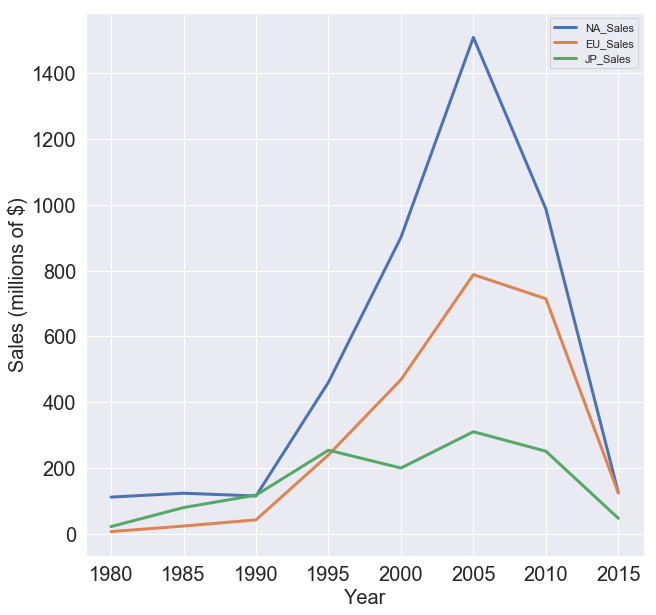

In [293]:
data_copy.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales']].sum().plot(figsize=(10,10), linewidth=3, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Sales (millions of $)', fontsize=20)
plt.savefig('Videogame_sales_across_markets_over_time.png', dpi=300, bbox_inches='tight')

We can calculate the percentage of total sales (globally) per region using the data.

In [ ]:
yearly_total_sales = data_copy.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().sum(axis=1)

In [294]:
data_copy.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().divide(yearly_total_sales/100, axis='rows')

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Year,,,,
1980.0,78.237473,5.017821,15.633517,1.111189
1985.0,53.005699,10.291786,34.328806,2.373709
1990.0,40.770454,15.133416,41.664605,2.431525
1995.0,46.270260,24.106730,25.551829,4.071180
2000.0,52.849139,27.485847,11.747382,7.917632
2005.0,51.365482,26.828363,10.574054,11.232101
2010.0,45.178448,32.700591,11.503797,10.617164
2015.0,37.436601,37.135271,14.162540,11.265589


## Which consoles are the most popular games on for each market?

To do this, sort the data by the sales for each game in a market, choose the top 100 sellings games, grouby the platforms, and then count the number of games in each platform.

In [295]:
data_byna = data.sort_values(by='NA_Sales', ascending=False) #sort by na_sales
data_byeu = data.sort_values(by='EU_Sales', ascending=False) #sort by eu_sales
data_byjp = data.sort_values(by='JP_Sales', ascending=False) #sort by jp_sales

na_top_platforms = data_byna.iloc[:100].groupby('Platform')['Platform'].count() # select top 100 games in na and count # of games per platform
eu_top_platforms = data_byeu.iloc[:100].groupby('Platform')['Platform'].count() # same as above but for in eu
jp_top_platforms = data_byjp.iloc[:100].groupby('Platform')['Platform'].count() # same as above but for in jp

top_platforms = pd.DataFrame([na_top_platforms, eu_top_platforms, jp_top_platforms], index=['NA', 'EU', 'JP'])

Let's visualize the data using a barplot. The height of each bar represents the fraction of the top 100 games by region that are on that specific console and the x-axis is the console.

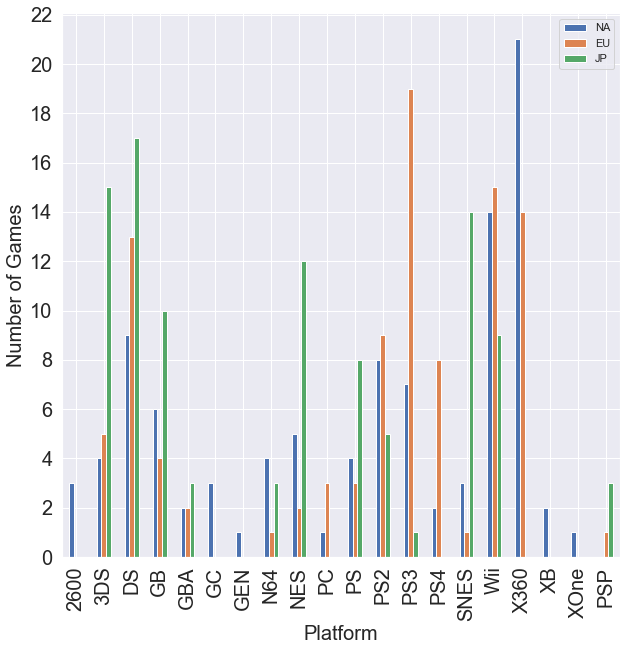

In [297]:
top_platforms.T.plot.bar(figsize=(10,10), fontsize=20);
plt.yticks(np.arange(0,24,2));
plt.xlabel('Platform', fontsize=20)
plt.ylabel('Number of Games', fontsize=20);
plt.savefig('Consoles_across_markets.png', dpi=300, bbox_inches='tight')

The highest selling games for NA tend to be on Xbox360 & Wii, EU tend to be on PS3 and Wii, and JP tend to be Nintendo DS and 3DS.

This is interesting in the fact that some of these consoles are obsolete, so how does the platform usage change over time? Let's calculate the top platforms over time for the top 20 games in each bin of years (for the 3 markets)

In [228]:
top_na_game_index = data_copy.groupby(['Year'])['NA_Sales'].nlargest(20).index.get_level_values(level=1) # get indices of top 20 games in na per bin of years
top_na_year_values = data_copy.loc[top_na_game_index].groupby(['Year', 'Platform'])['Rank'].count().max(level=0) / 20 # for the most popular platform in a bin of years, get the fraction of games on that platform
top_na_year_platforms_index = data_copy.loc[top_na_game_index].groupby(['Year', 'Platform'])['Rank'].count().reset_index().groupby('Year')['Rank'].idxmax() # get the indexes of the most popular platforms in each bin of years
top_na_year_platforms = data_copy.loc[top_na_game_index].groupby(['Year', 'Platform'])['Rank'].count().reset_index().loc[top_na_year_platforms_index, 'Platform'] # get the most popular platform in a bin of years

In [229]:
# same as above but for eu
top_eu_game_index = data_copy.groupby(['Year'])['EU_Sales'].nlargest(20).index.get_level_values(level=1)
top_eu_year_values = data_copy.loc[top_eu_game_index].groupby(['Year', 'Platform'])['Rank'].count().max(level=0) / 20
top_eu_year_platforms_index = data_copy.loc[top_eu_game_index].groupby(['Year', 'Platform'])['Rank'].count().reset_index().groupby('Year')['Rank'].idxmax()
top_eu_year_platforms = data_copy.loc[top_eu_game_index].groupby(['Year', 'Platform'])['Rank'].count().reset_index().loc[top_eu_year_platforms_index, 'Platform']

In [230]:
# same as above but for jp
top_jp_game_index = data_copy.groupby(['Year'])['JP_Sales'].nlargest(20).index.get_level_values(level=1)
top_jp_year_values = data_copy.loc[top_jp_game_index].groupby(['Year', 'Platform'])['Rank'].count().max(level=0) / 20
top_jp_year_platforms_index = data_copy.loc[top_jp_game_index].groupby(['Year', 'Platform'])['Rank'].count().reset_index().groupby('Year')['Rank'].idxmax()
top_jp_year_platforms = data_copy.loc[top_jp_game_index].groupby(['Year', 'Platform'])['Rank'].count().reset_index().loc[top_jp_year_platforms_index, 'Platform']

Let's visualize the results using a bar plot. We'll need to create a dictionary converting each platform to  a unique color in order to color our bars by platform)

In [231]:
cm = plt.get_cmap('tab20b')
color_dict = {}
for index in range(len(platforms)):
    color_dict[platforms[index]] = cm(index)

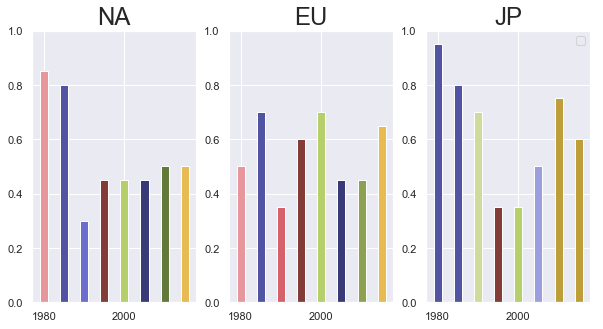

In [232]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].bar(year_ranges, top_na_year_values, width=2, color=list(map(color_dict.get, top_na_year_platforms)))
axs[1].bar(year_ranges, top_eu_year_values, width=2, color=list(map(color_dict.get, top_eu_year_platforms)))
axs[2].bar(year_ranges, top_jp_year_values, width=2, color=list(map(color_dict.get, top_jp_year_platforms)))
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)
axs[2].set_ylim(0,1)
handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles, labels, loc='upper right')
axs[0].set_title('NA', fontsize=24)
axs[1].set_title('EU', fontsize=24)
axs[2].set_title('JP', fontsize=24);
fig.savefig('Platforms_across_time.png', dpi=300, bbox_inches='tight')

I can't figure out how to show the legend. The height of the bars show the fraction of the top 20 games in that bin of years which were released for that platform. The color shows the platform. Although the heights of the bars are different, one can see similar trends between NA and EU for which platforms are utilized most (recently PS4, Xbox 360, and Wii). However, Japan has tended towards mobile platforms (DS, 3DS) in the past 10-15 years. This can be seen in the print outs of the top platforms by year below.

In [603]:
top_na_year_platforms, top_eu_year_platforms, top_jp_year_platforms

(0     2600
 3      NES
 4       GB
 12      PS
 17     PS2
 21     Wii
 27    X360
 28     PS4
 Name: Platform, dtype: object, 0     2600
 3      NES
 6       PC
 11      PS
 16     PS2
 20     Wii
 23     PS3
 28     PS4
 Name: Platform, dtype: object, 1      NES
 3      NES
 6     SNES
 9       PS
 16     PS2
 17      DS
 21     3DS
 25     3DS
 Name: Platform, dtype: object)

# Trending video game genres

Here we do the same calculation as before but now for genres instead of platforms

In [233]:
# this is the same as the previous code shown for the "platforms" section
top_na_game_index = data_copy.groupby(['Year'])['NA_Sales'].nlargest(20).index.get_level_values(level=1)
top_na_year_values = [ data_copy.loc[top_na_game_index].groupby(['Year', 'Genre'])['Rank'].count().loc[year].nlargest(3).values / 20 for year in year_ranges ]
top_na_year_genres = [ list(data_copy.loc[top_na_game_index].groupby(['Year', 'Genre'])['Rank'].count().loc[year].nlargest(3).keys()) for year in year_ranges ]

In [234]:
top_eu_game_index = data_copy.groupby(['Year'])['EU_Sales'].nlargest(20).index.get_level_values(level=1)
top_eu_year_values = [ data_copy.loc[top_eu_game_index].groupby(['Year', 'Genre'])['Rank'].count().loc[year].nlargest(3).values / 20 for year in year_ranges ]
top_eu_year_genres = [ list(data_copy.loc[top_eu_game_index].groupby(['Year', 'Genre'])['Rank'].count().loc[year].nlargest(3).keys()) for year in year_ranges ]

In [235]:
top_jp_game_index = data_copy.groupby(['Year'])['JP_Sales'].nlargest(20).index.get_level_values(level=1)
top_jp_year_values = [ data_copy.loc[top_jp_game_index].groupby(['Year', 'Genre'])['Rank'].count().loc[year].nlargest(3).values / 20 for year in year_ranges ]
top_jp_year_genres = [ list(data_copy.loc[top_jp_game_index].groupby(['Year', 'Genre'])['Rank'].count().loc[year].nlargest(3).keys()) for year in year_ranges ]

Let's visualize the results by plotting the top genres for each country throughout time

In [236]:
cm = plt.get_cmap('tab20b')
color_dict = {}
for index in range(len(genres)):
    color_dict[genres[index]] = cm(index)

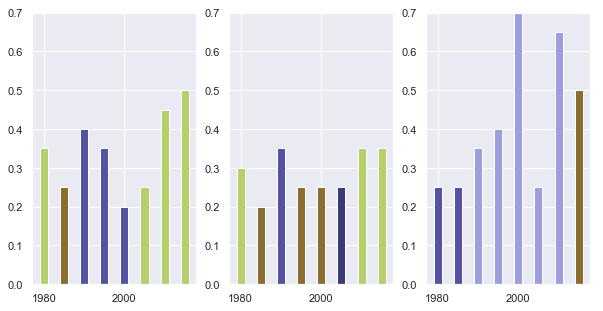

In [261]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].bar(year_ranges, width=2, height=[ item[0] for item in top_na_year_values ], color=list(map(color_dict.get, [ item[0] for item in top_na_year_genres ])))
axs[1].bar(year_ranges, width=2, height=[ item[0] for item in top_eu_year_values ], color=list(map(color_dict.get, [ item[0] for item in top_eu_year_genres ])))
axs[2].bar(year_ranges, width=2, height=[ item[0] for item in top_jp_year_values ], color=list(map(color_dict.get, [ item[0] for item in top_jp_year_genres ])))
axs[0].set_ylim(0,0.7)
axs[1].set_ylim(0,0.7)
axs[2].set_ylim(0,0.7)
fig.savefig('Genres_across_time.png', dpi=300, bbox_inches='tight')

Again, recently NA and EU have similar trends, with the top genre recently being Shooter (other popular are Platform and Action). In comparison, JP likes Role-Playing and Actions. This can be seen by the prinout of the top genres by year below.

In [610]:
[ item[0] for item in top_na_year_genres ], [ item[0] for item in top_eu_year_genres ], [ item[0] for item in top_jp_year_genres ]

(['Shooter',
  'Action',
  'Platform',
  'Platform',
  'Platform',
  'Shooter',
  'Shooter',
  'Shooter'],
 ['Shooter',
  'Action',
  'Platform',
  'Action',
  'Action',
  'Sports',
  'Shooter',
  'Shooter'],
 ['Platform',
  'Platform',
  'Role-Playing',
  'Role-Playing',
  'Role-Playing',
  'Role-Playing',
  'Role-Playing',
  'Action'])

# What features about a video game are most indicative about its success?

## Data wrangling

Let's take a look at the dataframe again to see which columns could potentially be predictors

In [238]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Let's predict global_sales using platform, year, genre, and publisher data using a linear regression.
    - Platform is categorical and will need to be OHE
    - Year is ordinal and can be normalized by dividing by the max (in order to maintain ratios between years) 
    - Genre is categorical and will need to be OHE
    - Publisher is categorical and will need to be OHE
    
Notably we don't want to use NAsales, EUsales, or JPsales as predictors, since they are obviously TOO correlated with global sales.

Let's make a copy of the dataframe and drop any missing indices which have missing values from the features we're using and OHE platforms, genres, and publishers

In [339]:
data_copy = data.dropna(subset=['Year', 'Publisher', 'Platform', 'Genre'], axis=0)

In [340]:
platforms_encoded = pd.get_dummies(data_copy['Platform'].values)
platforms_encoded = platforms_encoded.reset_index().drop(labels='index', axis=1);

In [341]:
genres_encoded = pd.get_dummies(data_copy['Genre'].values) 
genres_encoded = genres_encoded.reset_index().drop(labels='index', axis=1);

In [342]:
publishers_encoded = pd.get_dummies(data_copy['Publisher'].values)
publishers_encoded = publishers_encoded.reset_index().drop(labels='index', axis=1);

We don't want to OHE years, but instead lets "normalize" by dividing by the max year in dataframe. This allows us to keep ratios between years.

In [343]:
year = data_copy['Year']/2020
year = year.reset_index().drop(labels='index', axis=1);

Now we make the dataframe from which we will train and test our model.

In [344]:
model_data = pd.concat([platforms_encoded, genres_encoded, publishers_encoded, year], axis=1)
target = data_copy['Global_Sales']

In [345]:
X_train, X_test, y_train, y_test = train_test_split(model_data, target, test_size=0.30, random_state=42)

In [246]:
X_train.shape

(11403, 620)

## LinearRegression (LASSO)

We'll start by trying LinearRegression with L1 regularization in order to try to remove less important features (since we have so many)

In [247]:
clf = Lasso(max_iter = 1000, alpha=0.00001)
clf.fit(X_train, y_train)

/Users/stefanheinze/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
clf.predict(X_train)

array([0.32047315, 0.8367124 , 1.10240609, ..., 0.97520253, 0.08320293,
       0.18817087])

In [22]:
clf.score(X_test, y_test)

0.09535900839950195

The R^2 value is 0.09... not very good. Let's see if we can improve by modifying the L1 regularization term.

In [25]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] # regularization terms
for alpha in alphas:
    clf = Lasso(max_iter = 1000, alpha=alpha)
    clf.fit(X_train, y_train)
    print('The R2 value of the linear regression at alpha = {} is {:.2f}.'.format(alpha, clf.score(X_test, y_test)))

/Users/stefanheinze/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The R2 value of the linear regression at alpha = 1e-05 is 0.10.
The R2 value of the linear regression at alpha = 0.0001 is 0.09.
The R2 value of the linear regression at alpha = 0.001 is 0.09.
The R2 value of the linear regression at alpha = 0.01 is 0.07.
The R2 value of the linear regression at alpha = 0.1 is -0.00.
The R2 value of the linear regression at alpha = 1 is -0.00.


The best R^2 value is achieved for low regularization (i.e. we are not overfitting our data). Let's fit the LASSO regression again with this value and see what the top predictors of success are.

In [248]:
clf = Lasso(max_iter=5000, alpha=1e-5)
clf.fit(X_train, y_train)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [249]:
clf.score(X_test, y_test)

0.09536290644379342

In the following cell, we show the top 20 predictors of success

In [250]:
top_predictors = (-clf.coef_).argsort()[:20] # sort by coefficient size, largest first
X_train.iloc[:, top_predictors].columns

Index(['Red Orb', 'Nintendo', 'RedOctane', 'UEP Systems',
       'Arena Entertainment', 'Westwood Studios',
       'Sony Computer Entertainment Europe', 'GB', 'Bethesda Softworks',
       'Microsoft Game Studios', 'Hello Games', 'NES', 'Valve Software',
       'Imagic', 'Take-Two Interactive', 'LucasArts', 'Hasbro Interactive',
       'mixi, Inc', 'PS4', 'Maxis'],
      dtype='object')

Most of these appear to be publishers, but let's make sure. A few seem to be platforms.

In [134]:
for name in X_train.iloc[:, top_predictors].columns:
    if name not in publishers:
        print(name)

GB
NES
PS4


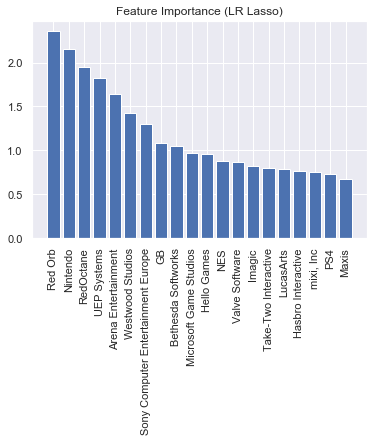

In [251]:
plt.bar(range(20), height = clf.coef_[top_predictors], tick_label=X_train.iloc[:, top_predictors].columns)
plt.xticks(rotation=90)
plt.title('Feature Importance (LR Lasso)');
plt.savefig('LASSO_FeatureImportance.png', dpi=300, bbox_inches='tight')

The results show that the top predictors of success are generally the publishers of the games, though the console is also important.

## LinearRegression (Ridge)

Here we try Ridge regression instead of LASSO, with the knowledge that this is not likely to do better than LASSO given the large number of features

In [53]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] # regularization term
for alpha in alphas:
    clf = Ridge(max_iter = 1000, alpha=alpha)
    clf.fit(X_train, y_train)
    print('The R2 value of the linear regression at alpha = {} is {:.2f}.'.format(alpha, clf.score(X_test, y_test)))

The R2 value of the linear regression at alpha = 1e-05 is 0.10.
The R2 value of the linear regression at alpha = 0.0001 is 0.10.
The R2 value of the linear regression at alpha = 0.001 is 0.10.
The R2 value of the linear regression at alpha = 0.01 is 0.09.
The R2 value of the linear regression at alpha = 0.1 is 0.09.
The R2 value of the linear regression at alpha = 1 is 0.09.


It does not appear that Ridge regression achieves a much higher accuracy, so let's move on to fitting a random forest model.

## Random Forest

First let's quickly fit a random forest model to our data

In [59]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

/Users/stefanheinze/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
clf.score(X_test, y_test)

0.021872929721502232

The model doesn't seem to be doing better than linear regressions, but let's quickly try tuning the hyperparameters

In [63]:
n_estimators = [10, 25, 50, 100] # number of trees
min_samples_split = [2, 10, 25, 50] # minimum number of samples needed to split a node

hp_list = []
for estimator in n_estimators:
    for sample in min_samples_split:
        clf = RandomForestRegressor(n_estimators=estimator, min_samples_split=sample)
        clf.fit(X_train, y_train)
        hp_list.append([estimator, sample, clf.score(X_test, y_test)])
        print('done')

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


Which hyperparameters gave us the best model? Let's check hp_list.

In [158]:
sorted(hp_list, key=lambda x: x[2], reverse=True) # largest accuracies shown first

[[10, 25, 0.1699884433180615],
 [10, 10, 0.13691880042434423],
 [100, 25, 0.1354636145848913],
 [50, 25, 0.1299819656770259],
 [25, 25, 0.12254985037407362],
 [50, 10, 0.1197261668216717],
 [50, 50, 0.11944430052299226],
 [100, 10, 0.11943963066226104],
 [25, 50, 0.11792376259833215],
 [100, 50, 0.11774991010825253],
 [10, 50, 0.11746612616737706],
 [25, 10, 0.10727788000542715],
 [50, 2, 0.061212190964022306],
 [100, 2, 0.051428379822678005],
 [25, 2, 0.030292913760314177],
 [10, 2, 0.00791305332412684]]

The best R^2 score is achieved for n_estimators = 10, min_samples_split = 25, with R^2=0.17. This is much better than linear regression, suggesting that the underlying function may not be linear.

Let's refit the best model and see what the top predictors are

In [348]:
clf = RandomForestRegressor(n_estimators=10, min_samples_split=25)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [349]:
clf.score(X_test, y_test)

0.1650801371379308

In the following cell we look at the top predictors of success.

In [350]:
top_predictors = (-clf.feature_importances_).argsort()[:20]
X_train.iloc[:, top_predictors].columns

Index(['Year', 'Nintendo', 'Role-Playing', 'Shooter', 'Racing', 'Action',
       'PS3', 'Platform', 'GB', 'Sports', 'Wii', 'Sony Computer Entertainment',
       'PS4', 'Electronic Arts', 'X360', 'Activision', 'Take-Two Interactive',
       'Microsoft Game Studios', 'PS2', 'Simulation'],
      dtype='object')

In [162]:
for name in X_train.iloc[:, top_predictors].columns:
    if name in publishers:
        print('publisher')
    elif name in genres:
        print('genres')
    elif name in platforms:
        print('platform')
    else:
        print('year')

year
publisher
platform
genres
genres
genres
genres
genres
platform
platform
genres
publisher
genres
publisher
platform
publisher
platform
publisher
platform
publisher


In contrast to the linear regression, we find that the best predictors of game success is a mix of publishers, year released, genre, and platform, with Year and Publisher Nintendo being the highest indicators of success.

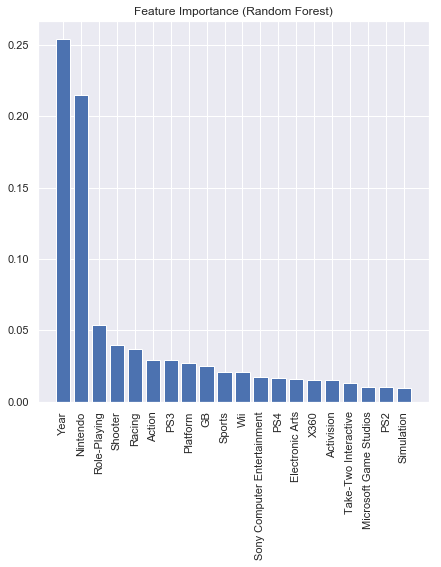

In [351]:
sns.set()
plt.figure(figsize=(7,7))
plt.bar(x=range(20), height=clf.feature_importances_[top_predictors], tick_label=X_train.iloc[:, top_predictors].columns)
plt.xticks(rotation=90)
plt.title('Feature Importance (Random Forest)');
plt.savefig('RF_featureimportance.png', dpi=300, bbox_inches='tight')

# Predictors of success in past 10 years

In the following cells, we repeat the random forest model but limit ourselves to the data from games in the past 10 years, since most publishers are interested in making a CURRENTLY popular game. The following code repeats what we already did previously, with the added feature of only looking at games made after 2010.

In [327]:
data_copy = data.dropna(subset=['Year', 'Publisher', 'Platform', 'Genre'], axis=0)
data_copy = data_copy[data_copy['Year'] >= 2010] # LIMIT TO PAST 10 YEARS!

In [328]:
platforms_encoded = pd.get_dummies(data_copy['Platform'].values)
platforms_encoded = platforms_encoded.reset_index().drop(labels='index', axis=1);

In [329]:
genres_encoded = pd.get_dummies(data_copy['Genre'].values)
genres_encoded = genres_encoded.reset_index().drop(labels='index', axis=1);

In [330]:
publishers_encoded = pd.get_dummies(data_copy['Publisher'].values)
publishers_encoded = publishers_encoded.reset_index().drop(labels='index', axis=1);

We don't want to OHE years, but instead lets "normalize" by dividing by the max year in dataframe. This allows us to keep ratios between years.

In [331]:
year = data_copy['Year']/2020
year = year.reset_index().drop(labels='index', axis=1);

Now we make the dataframe from which we will train and test our model.

In [332]:
model_data = pd.concat([platforms_encoded, genres_encoded, publishers_encoded, year], axis=1)
target = data_copy['Global_Sales']

In [333]:
X_train, X_test, y_train, y_test = train_test_split(model_data, target, test_size=0.30, random_state=42)

In [334]:
X_train.shape

(3593, 289)

In [335]:
clf = RandomForestRegressor(n_estimators=10, min_samples_split=25)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [336]:
clf.score(X_test, y_test)

0.254827258303026

In [337]:
top_predictors = (-clf.feature_importances_).argsort()[:20]
X_train.iloc[:, top_predictors].columns

Index(['Activision', 'Shooter', 'Action', 'Nintendo', 'Electronic Arts',
       'Year', 'Microsoft Game Studios', 'PS3', 'PS4', 'Racing',
       'Take-Two Interactive', 'X360', 'Platform',
       'Sony Computer Entertainment', 'Ubisoft', 'Fighting', 'Role-Playing',
       'Bethesda Softworks', 'Warner Bros. Interactive Entertainment', 'Wii'],
      dtype='object')

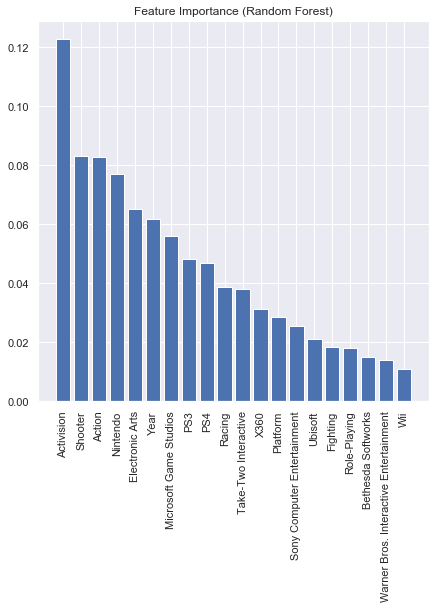

In [338]:
sns.set()
plt.figure(figsize=(7,7))
plt.bar(x=range(20), height=clf.feature_importances_[top_predictors], tick_label=X_train.iloc[:, top_predictors].columns)
plt.xticks(rotation=90)
plt.title('Feature Importance (Random Forest)');
plt.savefig('RF_featureimportance.png', dpi=300, bbox_inches='tight')